In [ ]:
import numpy as np 
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from IPython.display import clear_output, HTML

from google.colab import drive
drive.mount("/content/drive")


disable_eager_execution()

# Function to decode the predictions of a model
def decode_predictions(predictions):
  max_elem = np.max(predictions)
  result = np.where(predictions == max_elem)

  df = pd.read_csv(os.path.join('drive','My Drive','TFG','dataset','signnames.csv'))

  index = 4*result[0][0] + result[1][0]

  return df["SignName"][index]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
disable_eager_execution()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Prediction:  Speed limit (30km/h)
Raw predictions:  [[1.20671831e-01 8.60459387e-01 2.97517958e-03 1.67163616e-10
  5.92572125e-09 4.97814221e-03 1.09154563e-02 1.81987030e-11
  1.46926773e-08 3.10996915e-13 1.95797296e-19 5.19439745e-17
  9.75167213e-13 4.09256039e-15 3.68772450e-13 9.07930708e-19
  9.32454323e-14 6.45177838e-15 1.08069239e-21 7.38678852e-16
  8.43436710e-16 7.72557369e-21 1.76416428e-19 4.68956456e-16
  8.27530384e-16 5.28409857e-15 5.20458204e-21 7.91609139e-12
  2.79972209e-16 1.12353682e-13 5.64569173e-19 6.27176083e-17
  7.67887247e-17 5.27766460e-18 1.68954763e-18 1.16450191e-14
  1.52753406e-16 7.22313925e-23 4.57079947e-19 4.78206003e-15
  6.04295711e-19 1.04855266e-13 5.38429071e-15]]


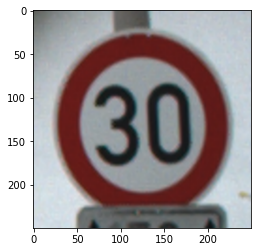

In [ ]:
source_class = 1
network_num  = 1

network = os.path.join('drive','My Drive','TFG','models',str(network_num),'model.h5')

# Load the model
model = load_model(network)

# Load image
im = Image.open(os.path.join('drive','My Drive','TFG','dataset','Test','00284.png'))
im = im.resize((250,250))
im = np.array(im)
im = im.reshape([1, im.shape[0], im.shape[1], im.shape[2]])

# Predict image class
y = model.predict(im)

res = decode_predictions(y)

plt.imshow(im[0])
print("Prediction: ", res)
print("Raw predictions: ", y)

Attack execution time:  0


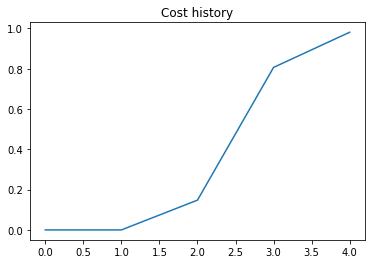

In [ ]:
#           ATTACK            #
###############################
attack_num = 34

# Target class
target_class = 6 # 80km/h
#target_class = 7 # 100km/h
#target_class = 8 # 120km/h

# Obtenim la forma de les capes d'entrada i sortida de la xarxa
inp_layer = model.layers[0].input
out_layer = model.layers[-1].output

# Funció de cost, volem maximitzar la classe llimona
loss = out_layer[0, target_class]

# Utilitzarem el gradinet, no sobre els paràmetres de la xarxa,
# sinó sobre la variable d'entrada (la imatge)
# Volem calcular el gradient entre la funció de cost i les dades d'entrada
grad = K.gradients(loss, inp_layer)[0]

# Funcio que optimitzarà el nostre gradient per obtenir l'input que
# volem per l'atac. Aquestes funcions de Keras demanen els inputs i
# outputs que necessiten.
# El K.learning_phase() s'ha de passar al model quan s'executa per 
# indicar que estem en procés d'entrenament o test
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

# Variable de cost
cost = 0.0

# Copia de la imatge per no perdre les dades originals
adv = np.copy(np.array(im, dtype=np.float32))

# Per que no es notin els canvis en l'input, definim la pertorbació i
# calculem el rang de valors que acceptarem
pert = 3

max_pert = np.clip(adv + pert, 0, 255)
min_pert = np.clip(adv - pert, 0, 255)

# Variables auxiliars
cost_history = np.empty([1])
start = datetime.datetime.utcnow()

# Atac adversari
while cost < 0.95:

  # Obtenim el valor dels píxels (amb el gradient) i el cost
  # Utilitzarem 0 per un mode TEST de learning_phase
  gr, cost = optimize_gradient([adv, 0])

  # Sumem aquest valor a la imatge per alterar-la
  if cost < 0.0001:
    adv += gr*10000000000000000
  elif cost < 0.001:
    adv += gr*100000
  elif cost < 0.1:
    adv += gr*10000
  else:
    adv += gr*10000

  # Reduïm els canvis a la pertorbació permesa
  adv = np.clip(adv, min_pert, max_pert)

  cost_history = np.append(cost_history, cost)
  plt.plot(cost_history)
  plt.show()

# Càlucl de temps i outputs
stop = datetime.datetime.utcnow()

clear_output()
attack_time = (stop - start).seconds
print('Attack execution time: ', attack_time)

plt.title("Cost history")
plt.plot(cost_history)
plt.savefig(os.path.join('drive','My Drive','TFG','attacks','meta',str(attack_num) + '_cost.jpg'))
plt.show()

Prediction:  End of speed limit (80km/h)
Raw predictions:  [[5.61430279e-05 2.76244609e-05 1.06926635e-02 3.15100984e-12
  3.05552472e-09 6.32281342e-07 9.89222050e-01 5.20689525e-07
  2.92247279e-07 2.45414959e-08 9.85081808e-12 2.00691785e-13
  2.71335132e-09 3.02170133e-09 8.89716034e-09 1.22790515e-12
  8.08698164e-10 2.75116846e-10 1.51601454e-16 3.36076077e-14
  1.63245326e-13 2.55459419e-16 3.69148012e-15 2.97146023e-11
  1.33159448e-13 7.68789823e-11 3.62557172e-20 2.49811404e-15
  1.13781597e-13 3.49533363e-13 3.06901768e-16 1.41067022e-13
  2.84805135e-09 1.03963884e-14 7.64934158e-11 1.26148744e-11
  2.44586404e-12 2.21436351e-15 3.34045638e-11 1.53231206e-08
  3.62778070e-15 1.12402461e-08 2.21323737e-10]]


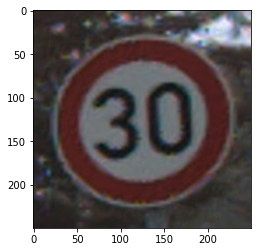

In [ ]:
att = np.array(adv, dtype=np.uint8)

# Predict image class
y2 = model.predict(att)

res2 = decode_predictions(y2)

plt.imshow(att[0])
print("Prediction: ", res2)
print("Raw predictions: ", y2)

In [ ]:
# Save results
data = {
    "Original class": [res],
    "Target class": [res2],
    "Target class code": [target_class],
    "Original class code": [source_class],
    "Attack time": [(stop - start).seconds]
}

df = pd.DataFrame(data)
df.to_csv(os.path.join('drive','My Drive','TFG','attacks','meta',str(attack_num) + '_details.csv'),index=False)

# Save image
hacked = Image.fromarray(att[0])
hacked.save(os.path.join('drive','My Drive','TFG','attacks',str(attack_num) + '_att.png'))



HTML(df.T.to_html(header=False))

Original class,Speed limit (30km/h)
Target class,End of speed limit (80km/h)
Target class code,6
Original class code,1
Attack time,0


In [ ]:
# Test the attack
test_model = load_model(network)

# Load image
im_test = Image.open(os.path.join('drive','My Drive','TFG','attacks',str(12) + '_att.png'))
im_test = im_test.resize((250,250))
im_test = np.array(im_test)
im_test = im_test.reshape([1, im_test.shape[0], im_test.shape[1], im_test.shape[2]])

# Predict image class
y3 = model.predict(im_test)

res3 = decode_predictions(y3)

print("Prediction: ", res3)
print("Raw predictions: ", y3)

# Show original image and hacked
fig=plt.figure(figsize=(8, 16))

fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title(res)
plt.imshow(im[0])

fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title(res3)
plt.imshow(im_test[0])
      
plt.show()

Prediction:  Speed limit (120km/h)
Raw predictions:  [[2.8983749e-02 2.5115261e-05 8.3913216e-03 5.0543484e-08 1.4898801e-07
  2.5055537e-04 1.6865192e-03 2.9911032e-08 9.6066254e-01 3.2310686e-13
  2.0853677e-16 8.0997302e-13 2.6879071e-10 9.9837872e-12 2.3931879e-10
  3.9049805e-13 1.4377265e-10 2.7405556e-10 4.4899575e-18 5.3935023e-14
  5.7430679e-12 1.7673382e-17 9.1242872e-15 3.7909599e-11 8.3544846e-13
  4.1801315e-10 2.1783054e-16 4.6792512e-09 1.4445713e-13 1.3097297e-09
  2.8091369e-15 9.3093475e-14 2.0736653e-10 2.9962647e-12 1.4953660e-11
  1.5779051e-09 6.2945253e-11 3.1928556e-19 2.2595725e-13 1.0161808e-14
  5.1216258e-13 2.8393505e-12 3.0209455e-12]]


# Test the attack on a different network

As we have seen, when an attack designed for one network is used as an input for another network, we have 3 different outputs:

1. The network is fooled and the attack works, we get the output we want.
2. The network is fooled but the attack doesn't works, we get a random output.
3. The network isn't fooled and the attack doesn't works, we get the correct output.

The goal is to build a histogram to analyze which scenario is more probable to encounter in the real world when we use an attack as an input for a different network.

In [ ]:
def test_attacks(model):
  attacks = 34
  test_results = []

  for i in range(1,attacks+1):
    # Load image
    im = Image.open(os.path.join('drive','My Drive','TFG','attacks',str(i)+'_att.png'))
    im = im.resize((250,250))
    im = np.array(im)
    im = im.reshape([1, im.shape[0], im.shape[1], im.shape[2]])

    pred = decode_predictions(model.predict(im))

    df = pd.DataFrame(pd.read_csv(os.path.join('drive','My Drive','TFG','attacks','meta',str(i)+'_details.csv')))

    expected = df["Target class"][0]
    input = df["Original class"][0]

    print("   - Test {}:".format(i))
    print("       - I: '{}'".format(input))
    print("       - E: '{}'".format(expected))
    print("       - O: '{}'".format(pred))

    if expected == pred:
      test_results.append(1)
    elif pred == input:
      test_results.append(3)
    elif expected!=pred and expected!=input:
      test_results.append(2)
    else:
      test_results.append(4)

  return test_results

In [ ]:
# Run tests in model 2
print("Running tests on model 2:")
model = load_model(os.path.join('drive','My Drive','TFG','models','2','model.h5'))
results2 = test_attacks(model)

np.savetxt(os.path.join('drive','My Drive','TFG','attacks','test','tests2.csv'), np.array(results2), delimiter=",")

Running tests on model 2:


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   - Test 1:
       - I: 'Speed limit (30km/h)'
       - E: 'Speed limit (100km/h)'
       - O: 'Speed limit (70km/h)'
   - Test 2:
       - I: 'Speed limit (30km/h)'
       - E: 'Speed limit (120km/h)'
       - O: 'Speed limit (70km/h)'
   - Test 3:
       - I: 'Speed limit (30km/h)'
       - E: 'Speed limit (100km/h)'
       - O: 'Speed limit (30km/h)'
   - Test 4:
       - I: 'Speed limit (30km/h)'
       - E: 'Stop'
       - O: 'Speed limit (70km/h)'
   - Test 5:
       - I: 'Speed limit (30km/h)'
       - E: 'Speed limit (120km/h)'
       - O: 'Speed limit (30km/h)'
   - Test 6:
       - I: 'Yield'
       - E: 'Speed limit (120km/h)'
       - O: 'Slippery road'
   - Test 7:
       - I: 'Yield'
       - E: 'Speed limit (100km/h)'
       - O: 'Slippery road'
   - Test 8:
       - I: 'Yield'
       - E: 'End of speed limit (80km/h)'
       - O: 'Slippery road'
   - Test 9:
       - I: 'Speed limit (50km/h)'
       - E: 'End of speed limit (80km/h)'
       - O: 'Speed limit (60km/h)'


In [ ]:
# Run tests in model 3
print("Running tests on model 3:")
model = load_model(os.path.join('drive','My Drive','TFG','models','3','model.h5'))
results3 = test_attacks(model)

np.savetxt(os.path.join('drive','My Drive','TFG','attacks','test','tests3.csv'), np.array(results3), delimiter=",")

Running tests on model 3:


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   - Test 1:
       - I: 'Speed limit (30km/h)'
       - E: 'Speed limit (100km/h)'
       - O: 'Double curve'
   - Test 2:
       - I: 'Speed limit (30km/h)'
       - E: 'Speed limit (120km/h)'
       - O: 'Double curve'
   - Test 3:
       - I: 'Speed limit (30km/h)'
       - E: 'Speed limit (100km/h)'
       - O: 'Double curve'
   - Test 4:
       - I: 'Speed limit (30km/h)'
       - E: 'Stop'
       - O: 'Double curve'
   - Test 5:
       - I: 'Speed limit (30km/h)'
       - E: 'Speed limit (120km/h)'
       - O: 'Double curve'
   - Test 6:
       - I: 'Yield'
       - E: 'Speed limit (120km/h)'
       - O: 'Double curve'
   - Test 7:
       - I: 'Yield'
       - E: 'Speed limit (100km/h)'
       - O: 'Double curve'
   - Test 8:
       - I: 'Yield'
       - E: 'End of speed limit (80km/h)'
       - O: 'Double curve'
   - Test 9:
       - I: 'Speed limit (50km/h)'
       - E: 'End of speed limit (80km/h)'
       - O: 'Double curve'
   - Test 10:
       - I: 'Speed limit (50km/h)'
  

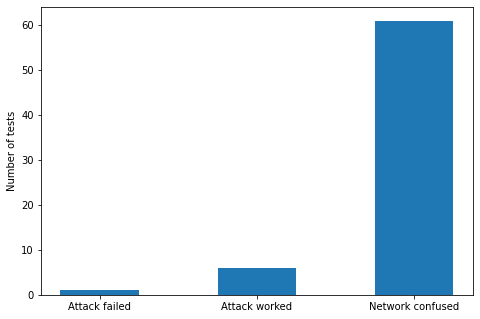

[1, 6, 61]


<Figure size 432x288 with 0 Axes>

In [ ]:
t2 = np.genfromtxt(os.path.join('drive','My Drive','TFG','attacks','test','tests2.csv'),delimiter=',')
t3 = np.genfromtxt(os.path.join('drive','My Drive','TFG','attacks','test','tests3.csv'),delimiter=',')

x = np.array(np.concatenate((t2, t3)), dtype=np.uint16)

# draw histogram
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
axis = ['Attack failed', 'Attack worked', 'Network confused']
data = [len(x[x==1]),len(x[x==3]),len(x[x==2])]
ax.bar(axis,data, 0.5)

plt.ylabel('Number of tests')
plt.show()
plt.savefig(os.path.join('drive','My Drive','TFG','attacks','test','histogram.svg'))

print(data)